In [1]:
import numpy as np
import matplotlib 
%matplotlib notebook
from matplotlib import pyplot as plt
from random import choice
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import f1_score

In [2]:
# PARAMETERS
LABELS = { 
'UNDEFINED':-1,
'OFF' : 0,
'BOOTUP' : 1,
'ON' : 2,
'HIGH' : 3,
'REBOOT' : 4 
}

colors = ['cornflowerblue', 'red', 'orange', 'green', 'blue', 'purple',]

named_colors = {}
for i,name in enumerate(LABELS.keys()):
    named_colors[name] = colors[i]

NOISE = 20

In [3]:
# STATE GENERATION FUNCTIONS

def get_label_name(label):
    for key, value in LABELS.items():
        if value == label:
            return(key)
    return(None)

def off():
    trace = np.array(200*[4]).reshape(1,-1)
    trace = trace + np.random.rand(1,trace.shape[1])*NOISE
    label = np.ones((1,trace.shape[1])) * LABELS['OFF']
    return(trace, label)

def bootup():
    ramp_1 = np.arange(0,100,5).reshape(1,-1)
    plat_1 = (np.ones((50,))*100).reshape(1,-1)
    ramp_2 = np.arange(100,200,3).reshape(1,-1)
    trace = np.concatenate((ramp_1,plat_1,ramp_2),axis=1)
    trace = trace + np.random.rand(1,trace.shape[1])*NOISE
    label = np.ones((1,trace.shape[1])) * LABELS['BOOTUP']
    return(trace,label)

def on():
    trace = np.array(200*[200]).reshape(1,-1)
    label = np.ones((1,trace.shape[1])) * LABELS['ON']
    trace = trace + np.random.rand(1,trace.shape[1])*NOISE
    return(trace,label)

def high():
    trace = np.array(200*[230]).reshape(1,-1)
    label = np.ones((1,trace.shape[1])) * LABELS['HIGH']
    trace = trace + np.random.rand(1,trace.shape[1])*NOISE
    return(trace,label)

def reboot():
    t0 = np.array(10*[240]).reshape(1,-1)
    t1 = np.array(10*[150]).reshape(1,-1)
    t2 = np.arange(150,170, 5).reshape(1,-1)
    t3 = np.arange(170,100, -10).reshape(1,-1)
    t4 = (np.ones((25,))*100).reshape(1,-1)
    t5 = np.arange(100,200,10).reshape(1,-1)
    trace = np.concatenate((t0,t1,t2,t3,t4,t5),axis=1)
    trace = trace + np.random.rand(1,trace.shape[1])*NOISE
    label = np.ones((1,trace.shape[1])) * LABELS['REBOOT']
    return(trace,label)

def get_complete_sequence(N=20):
    atoms = [off,bootup,on,high,reboot]

    sequence = [choice(atoms) for i in range(N)]
    #sequence = [off, bootup, on, off, off, bootup, on, on1, on, on1, on, reboot, on, reboot, on, off]

    trace, labels = sequence[0]()
    each_trace = [trace]
    each_labels = [labels]

    for f in sequence[1:]:
        ntrace, nlabel = f()
        each_trace.append(ntrace)
        each_labels.append(nlabel)
        trace = np.concatenate((trace,ntrace),axis=1)
        labels = np.concatenate((labels,nlabel),axis=1)

    return(trace,labels, each_trace, each_labels)

def get_protos():
    protos = {}
    maxN = 0
    for f,name in zip([off,bootup,on,high,reboot],['OFF','BOOTUP','ON','HIGH','REBOOT']):
        trace,label = f()
        protos[name] = trace
        maxN = max(maxN,trace.shape[1])
    return(protos, maxN)

def norm_distance(snippet,trace):
    distance = euclidean_distances(snippet, trace)/snippet.shape[1]
    return(distance)
def non_norm_distance(snippet,trace):
    distance = euclidean_distances(snippet, trace)
    return(distance)

    
def evaluate_detection(true_labels, detected_labels):
    #print(f"Evaluating detection from {name}")
    unique_labels = list(dict.fromkeys(detected_labels[0].tolist()).keys())
    scores = []
    for lab in unique_labels:
        score = f1_score(true_labels[0], detected_labels[0],labels = [lab], average='macro')
        #print(f"Label {lab}: {score}")
        scores.append(score)

    macro = f1_score(true_labels[0], detected_labels[0], average='macro')
    micro = f1_score(true_labels[0], detected_labels[0], average='micro')
    #print(f"Overall score: {round(macro,3)} macro, {round(micro,3)} micro\n")
    
    return(macro)

# Build detector

<IPython.core.display.Javascript object>


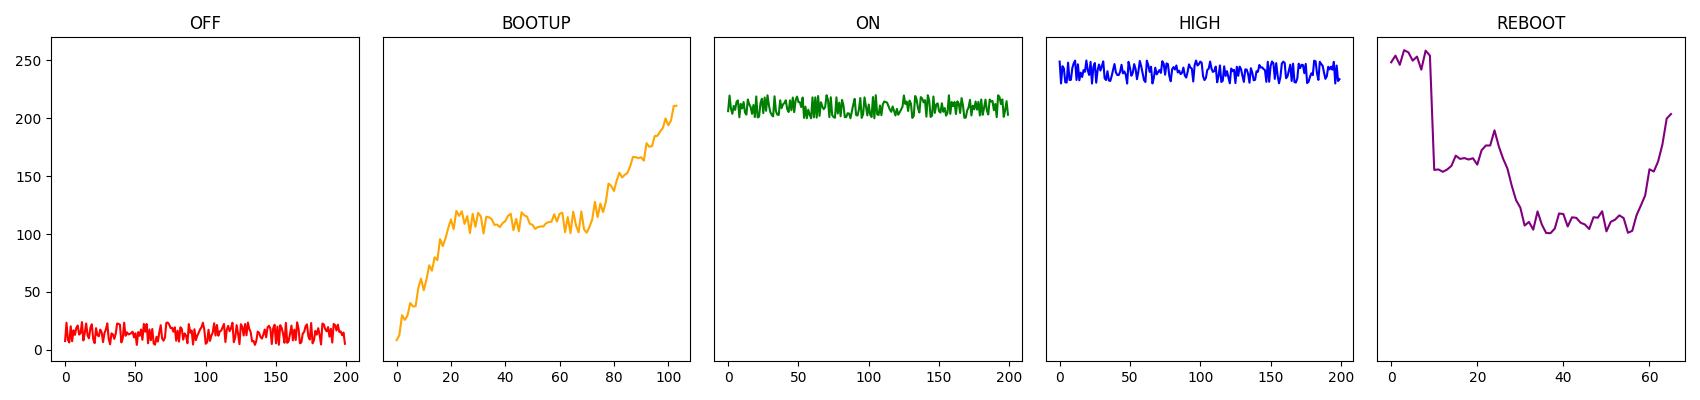

In [4]:
# Get protos
protos, maxN = get_protos()
fig_proto, axs_proto = plt.subplots(1, len(protos.keys()),figsize=(17,4))
for c,name in enumerate(protos.keys()):
    p = protos[name]
    axs_proto[c].plot(p[0],color = named_colors[name])
    axs_proto[c].set_ylim(-10,270)
    if c > 0:
        axs_proto[c].set_yticks([])
    axs_proto[c].set_title(name)
fig_proto.tight_layout()
fig_proto.savefig('protos.pdf',transparent=True)
fig_proto.show()

<IPython.core.display.Javascript object>


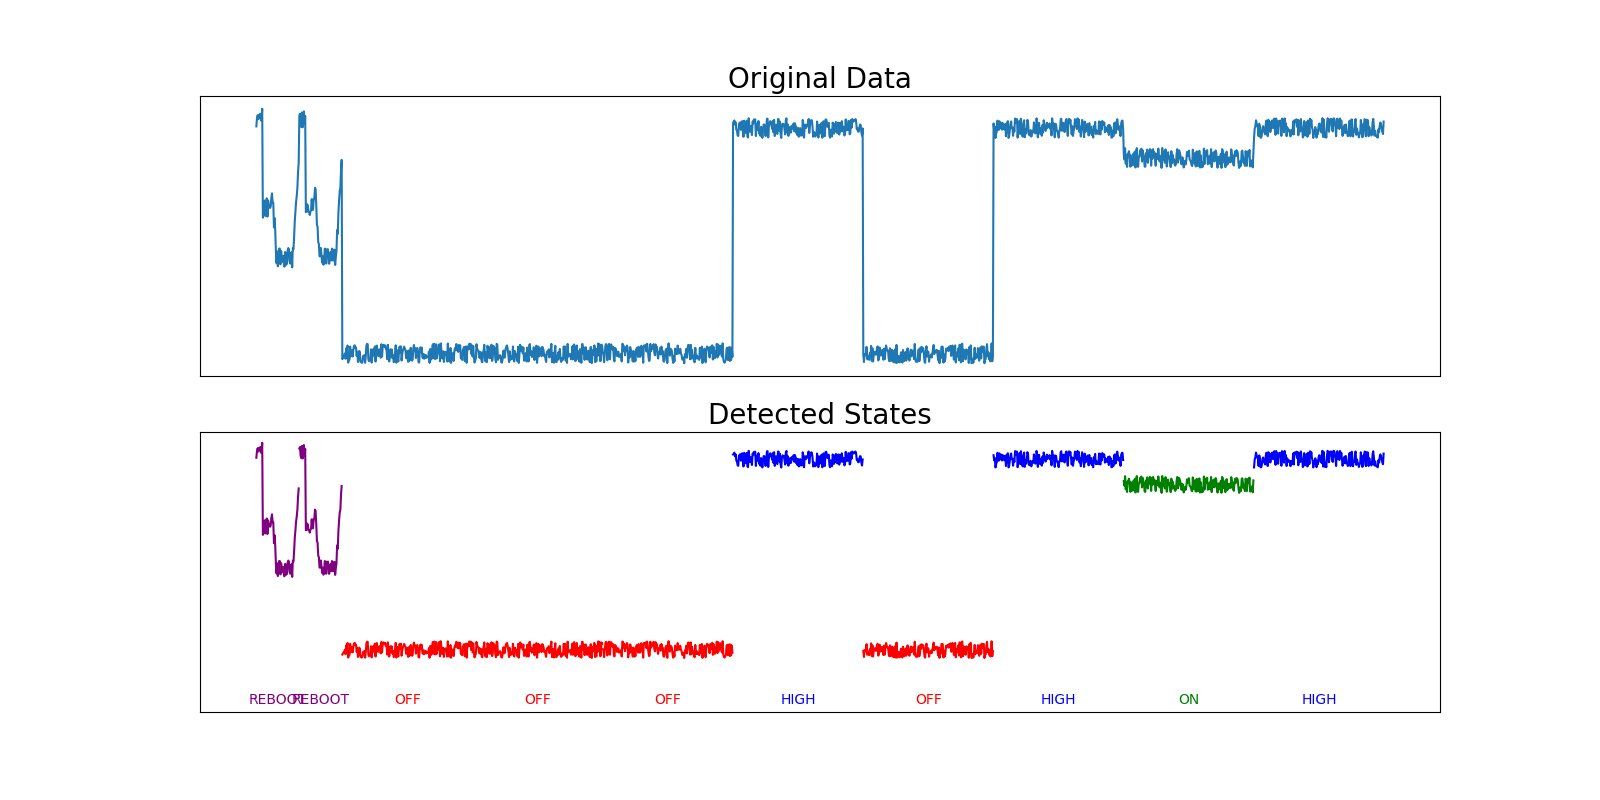

In [52]:
# Get Complete trace
trace, labels, each_trace, each_labels = get_complete_sequence(N=10)

ab = np.arange(0,trace.shape[1],1)

fig_t, axs_t = plt.subplots(2,1,figsize=(16,8))
axs_t[0].plot(ab,trace[0])

i = 0
legends = []
for t,l in zip(each_trace,each_labels):
    name = get_label_name(l[0,0])
    if name not in legends:
        legends.append(name)
        tag = name
    else:
        tag = '__empty'
    
    axs_t[1].plot(np.arange(i,i+t.shape[1],1),t[0], label = tag, color = named_colors[name])
    axs_t[1].text(i+t.shape[1]//2,-50,s=name,ha='center',color = named_colors[name],fontsize='10')
    i+=t.shape[1]
    
axs_t[0].set_xticks([])
axs_t[0].set_yticks([])
axs_t[1].set_xticks([])
axs_t[1].set_yticks([])
axs_t[0].set_title('Original Data',fontsize=20)
axs_t[1].set_title('Detected States',fontsize=20)

#axs_t[1].legend(loc='best')
axs_t[1].set_ylim(-60)
fig_t.show()

In [6]:
fig_t.tight_layout()
fig_t.savefig('trace.pdf',transparent=True)

<IPython.core.display.Javascript object>


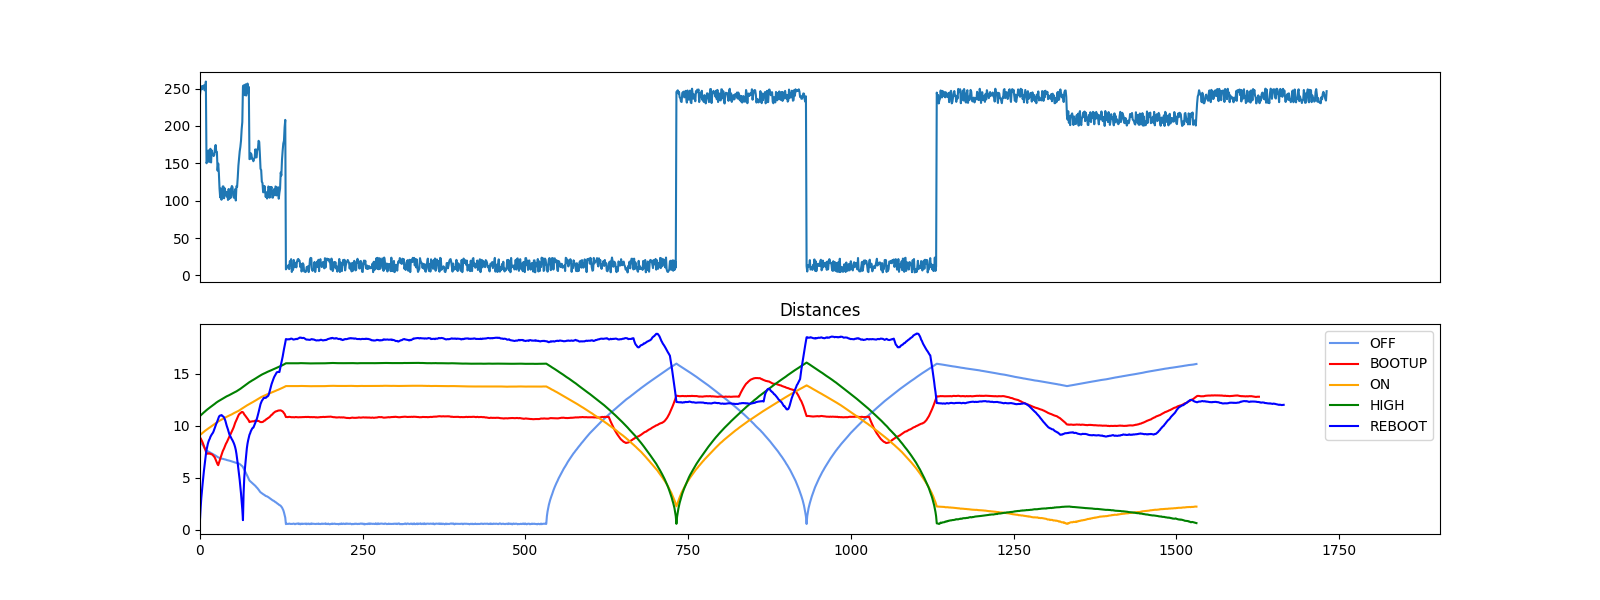

In [53]:
# Compute distance of protos to complete trace for each point
distances = {}
for name in protos.keys():
    proto = protos[name]
    d = np.zeros((1,trace.shape[1]-proto.shape[1]))
    for i in range(d.shape[1]):
        d[0,i] = norm_distance(proto,trace[:,i:i+proto.shape[1]])
    distances[name] = d

fig_d, axs_d = plt.subplots(2,1,figsize=(16,6))
axs_d[0].plot(trace[0])
for c,name in enumerate(distances.keys()):
    d = distances[name]
    axs_d[1].plot(d[0],label=name, color = colors[c])
axs_d[1].legend(loc='best')
axs_d[0].set_xlim(0,1.1 * trace.shape[1])
axs_d[0].set_xticks([])
axs_d[1].set_xlim(0,1.1 * trace.shape[1])
axs_d[1].set_title('Distances')
fig_d.show()

1531


<IPython.core.display.Javascript object>


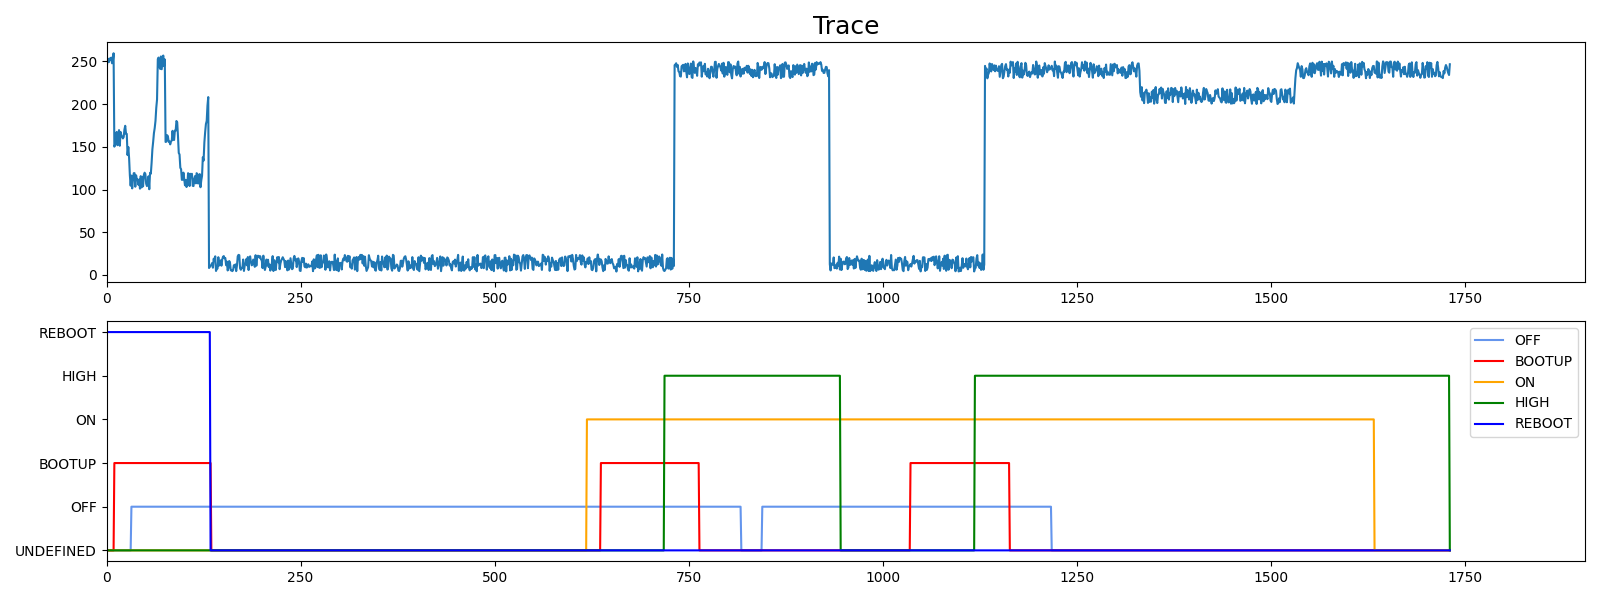

In [54]:
activations = np.ones((len(protos.keys()), trace.shape[1])) * -1

for k in range(trace.shape[1]-maxN):
    min_distance = np.inf
    min_class = ""
    min_proto = None
    
    for name in protos.keys():
        proto = protos[name]
        dist = norm_distance(proto, trace[:,k:k+proto.shape[1]])
        #print(f"Distance to {name} = {dist}")
        if dist < min_distance:
            min_distance = dist
            min_class = name
            min_proto=proto
    #print(f"Closest is {min_class}")
    activations[LABELS[min_class],k:k+min_proto.shape[1]] = LABELS[min_class]
        
print(k)

fig_act, axs_act = plt.subplots(2,1,figsize=(16,6))
axs_act[0].plot(trace[0])
for c,activation in enumerate(activations):
    axs_act[1].plot(activation,label=get_label_name(c), color = colors[c])
axs_act[1].legend(loc='best')
axs_act[0].set_xlim(0,1.1 * trace.shape[1])
#axs_act[0].set_xticks([])
axs_act[1].set_xlim(0,1.1 * trace.shape[1])
axs_act[1].set_yticks([-1,0,1,2,3,4])
axs_act[1].set_yticklabels([get_label_name(v) for v in axs_act[1].get_yticks()])
#axs_act[1].set_title('Activations',fontsize=18)
axs_act[0].set_title('Trace',fontsize=18)
fig_act.tight_layout()
fig_act.savefig('overlap.pdf', transparent=True)
fig_act.show()

['OFF', 'BOOTUP', 'REBOOT', 'ON', 'HIGH']


<IPython.core.display.Javascript object>


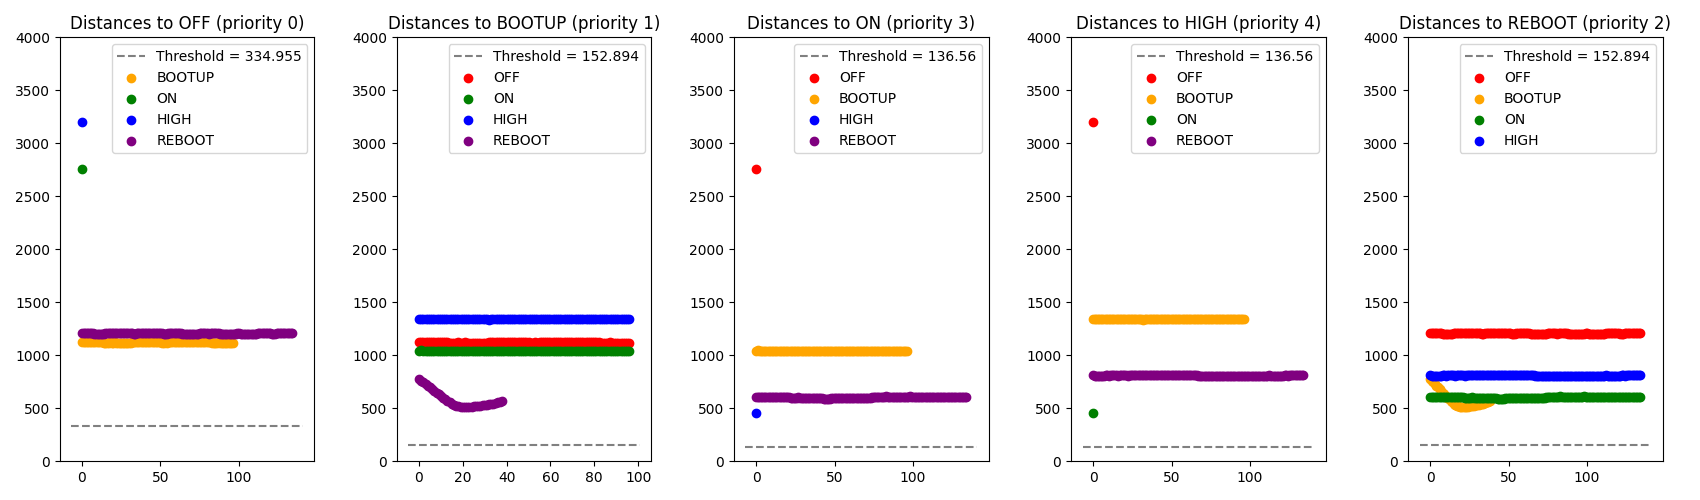

In [55]:
# Compute inter-distances, threshold and priorities
threshold_coef = 0.6
inter_distances = {}
thresholds = {}
for name in protos.keys():
    ref = protos[name]
    inter_distances[name] = {}
    thresholds[name] = np.Inf
    
    for i,name_sec in enumerate([pname for pname in protos.keys() if pname != name]):
        sec = protos[name_sec]
        
        if ref.shape[1] == sec.shape[1]:
            dist = [non_norm_distance(sec,ref)[0,0]]
        else:
            if ref.shape[1] > sec.shape[1]:
                #print(f"{name} is bigger that {name_sec}")
                big=ref
                small=sec
            else:
                #print(f"{name} is smaller that {name_sec}")
                big=sec
                small=ref

            dist = []
            #print(f"{big.shape[1]-small.shape[1]} values")
            for k in range(big.shape[1]-small.shape[1]+1):
                dist.append(non_norm_distance(small,big[:,k:k+small.shape[1]])[0,0])
                
        inter_distances[name][name_sec]=dist
        thresholds[name] = min(thresholds[name],min(dist)/2*threshold_coef)
    

priorities = sorted(thresholds.keys(), key=lambda key:thresholds[key],reverse=True)
print(priorities)
    
            
fig_inter, axs_inter = plt.subplots(1,len(inter_distances.keys()),figsize=(17,5))
for n,name in enumerate(distances.keys()):
    for d,name_sec in enumerate(inter_distances[name].keys()):
        dist = inter_distances[name][name_sec]
        axs_inter[n].scatter(np.arange(0,len(dist),1),dist,label=name_sec, color = named_colors[name_sec])
    axs_inter[n].plot(axs_inter[n].get_xlim(),2*[thresholds[name]],linestyle='dashed', color='grey', label = f"Threshold = {round(thresholds[name],3)}")
    axs_inter[n].set_ylim(bottom=0)
    axs_inter[n].legend(loc='best')
    axs_inter[n].set_title(f"Distances to {name} (priority {priorities.index(name)})")
    axs_inter[n].set_ylim(0,4000)
fig_inter.tight_layout()
fig_inter.savefig('inter_distances.pdf',transparent=True)
fig_inter.show()

Computing distances...
Compacting distances...


<IPython.core.display.Javascript object>


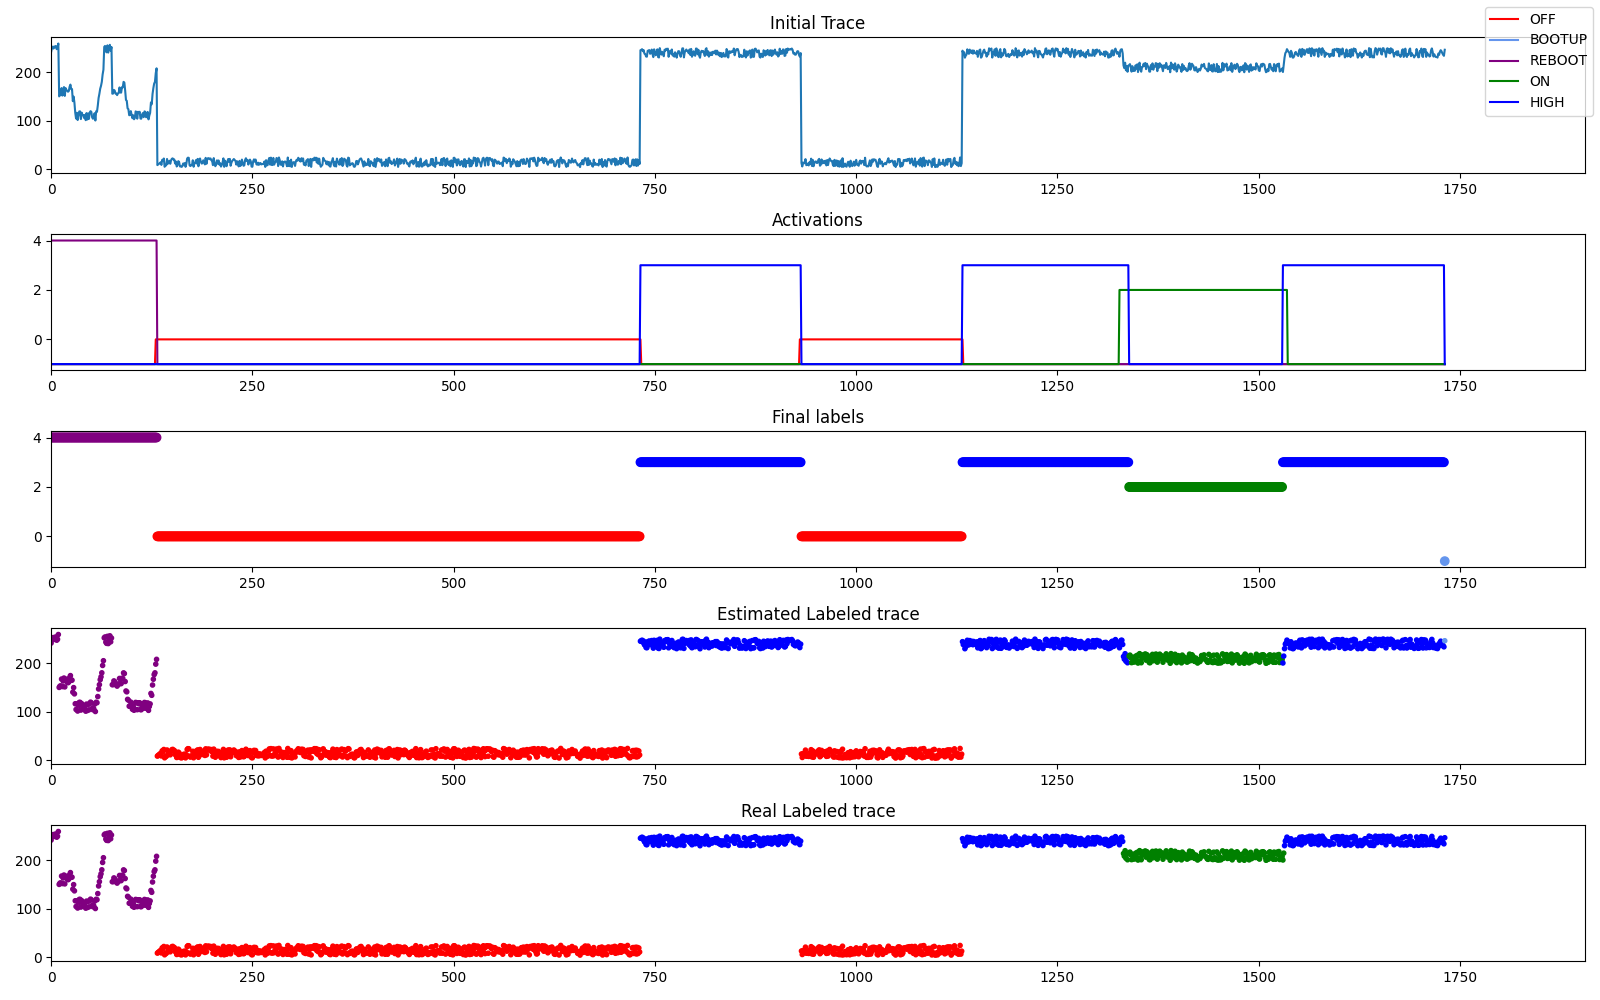

In [56]:
# Perform detection
# prepare data structure
print("Computing distances...")
detected_labels = np.ones((len(protos.keys()), trace.shape[1]), dtype=int) * -1
for i,key in enumerate(protos.keys()):
    row = priorities.index(key)
    proto = protos[key]
    pl = proto.shape[1]
    for j in range(trace.shape[1]-proto.shape[1]):
        dist = non_norm_distance(proto,trace[:,j:j+pl])
        if dist < thresholds[key]:
            detected_labels[row,j:j+pl] = LABELS[key]


# compact all labels
print("Compacting distances...")
final_labels = np.ones((1,detected_labels.shape[1]), dtype=int) * -1
for j in range(detected_labels.shape[1]):
    i = detected_labels.shape[0]-1
    while i>=0 and detected_labels[i,j] == -1:
        i-=1
    final_labels[0,j] = detected_labels[i,j]
    

fig_d, axs_d = plt.subplots(5,1,figsize=(16,10))
# 0 trace
axs_d[0].plot(trace[0])

# 1 each distances
ab = np.arange(0,detected_labels.shape[1],1)
for c,d in enumerate(detected_labels):
    axs_d[1].plot(ab,d, color = named_colors[get_label_name(max(d))], label = priorities[c])
    
# 2 final detected labels
c = [named_colors[get_label_name(l)] for l in final_labels[0]]
axs_d[2].scatter(ab, final_labels[0], color = c)

# 3 colors trace
axs_d[3].scatter(ab, trace[0], color = c, marker='.')

# 4 colors trace

c = [named_colors[get_label_name(l)] for l in labels[0]]
axs_d[4].scatter(ab, trace[0], color = c, marker='.')

# Parameters

lines_labels = [ax.get_legend_handles_labels() for ax in fig_d.axes]
lines, labs = [sum(lol, []) for lol in zip(*lines_labels)]
fig_d.legend(lines, labs)

#axs_d[1].legend(loc='best')
axs_d[0].set_xlim(0,1.1 * trace.shape[1])
axs_d[1].set_xlim(0,1.1 * trace.shape[1])
axs_d[2].set_xlim(0,1.1 * trace.shape[1])
axs_d[3].set_xlim(0,1.1 * trace.shape[1])
axs_d[4].set_xlim(0,1.1 * trace.shape[1])
axs_d[0].set_title('Initial Trace')
axs_d[1].set_title('Activations')
axs_d[2].set_title('Final labels')
axs_d[3].set_title('Estimated Labeled trace')
axs_d[4].set_title('Real Labeled trace')
fig_d.tight_layout()
fig_d.savefig(f'detection_{threshold_coef}.pdf',transparent=True)
fig_d.show()

In [57]:
# Compute score

score = evaluate_detection(labels, final_labels)
print(f"F1 Score of cross comparison detector: {score}")

hit,miss = 0,0
for r,d in zip(labels[0],final_labels[0]):
    if r==d:
        hit +=1
    else:
        miss +=1
        
print(f"Accuracy of cross comparison detector: {hit/labels.shape[1]}")

F1 Score of cross comparison detector: 0.7937407902982673
Accuracy of cross comparison detector: 0.9942263279445728
